In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import os
import PIL.Image as Image
from IPython.display import display

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Load the images
Load the images from the three sets (train, validation, and test). Since the images will be fed to a pretrained model for feature extraction, make sure to set the scale of the pixels and the image size as expected by the model (you can check the expected scale and size in the official documentation page)

In [2]:
### Create directories for train, valid and test images
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, 'swissroads/train/')
valid_dir = os.path.join(base_dir, 'swissroads/valid/')
test_dir = os.path.join(base_dir, 'swissroads/test/')
### Create a list of categories/labels
categories = os.listdir(train_dir)
categories

['bike', 'car', 'motorcycle', 'other', 'truck', 'van']

# 2. Visualize the images
Plot a few images from each category (bike, car, motorcycle, other, truck, van).

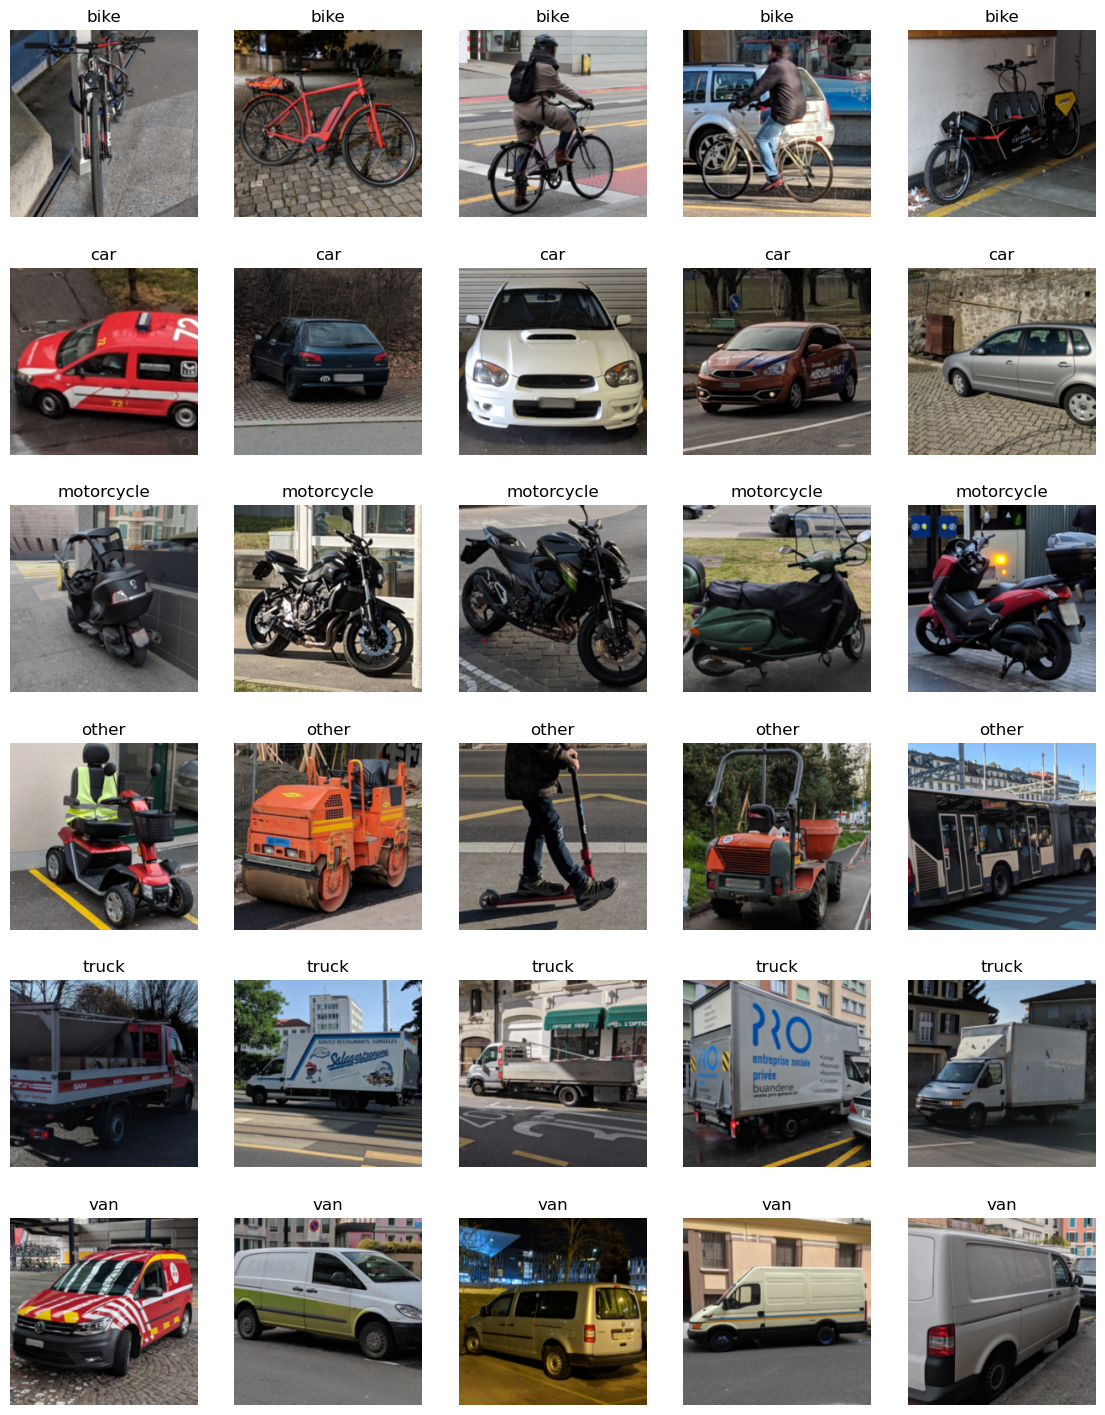

In [3]:
### Plot 5 images for each category
fig, axs = plt.subplots(6, 5)
fig.set_figheight(18)
fig.set_figwidth(14)

j = 0
for cat in categories:
    i = 0
    for im in  os.listdir(train_dir+cat)[:5]:
        img = Image.open(train_dir+cat+'/'+im)
        img_resized = img.resize([224, 224], resample=Image.BILINEAR)
        img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :] / 255
        axs[j][i].imshow(img_resized)
        axs[j][i].set_title(cat)
        axs[j][i].axis("off")
        i = i + 1
    j = j + 1

# 3. Proportion of the categories
Use an appropriate visualization to show the proportions of each category in the three sets (train, validation, and test).

In [4]:
### Create lists with the proportion of each category
prop_train = [len(os.listdir(train_dir + x)) for x in categories]
prop_valid = [len(os.listdir(train_dir + x)) for x in categories]
prop_test = [len(os.listdir(train_dir + x)) for x in categories]

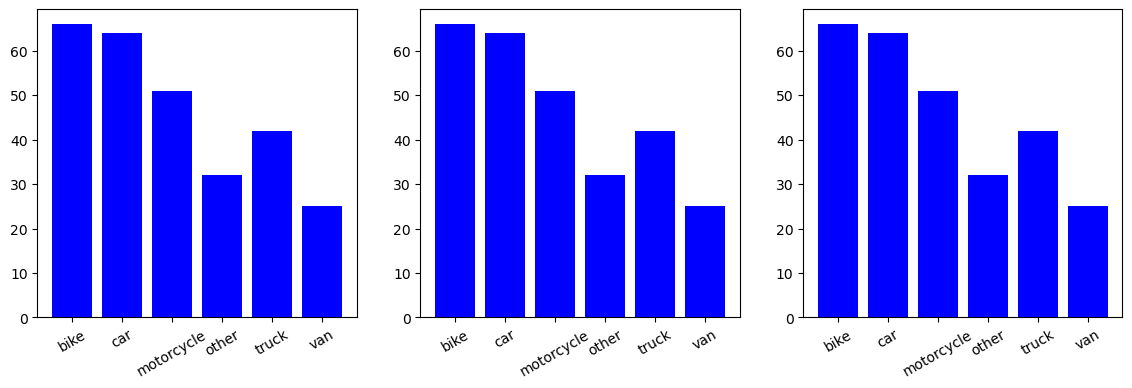

In [5]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(14)
fig.set_figheight(4)
ax[0].bar(x=categories, height=prop_train, color='blue')
ax[0].tick_params(axis='x', rotation=30)
ax[1].bar(x=categories, height=prop_valid, color='blue')
ax[1].tick_params(axis='x', rotation=30)
ax[2].bar(x=categories, height=prop_test, color='blue')
ax[2].tick_params(axis='x', rotation=30)

Even if the categories do not have the same proportions, there is no clear inbalanced data.  
The data for the categories **other** and **van** are almost the 50% of the categories **bike** and **car**.

# 4. Extract the high-level features
Extract the **high-level features** for all the images in the three datasets using MobileNet v2. Consider storing the extracted high-level features, e.g. in npz files, for quickly reloading them into each of the following notebooks.

In [6]:
### Set the image and the batch sizes for the pre-trained model
IMG_SIZE = 224
BATCH_SIZE = 32

### Image Augmentation
### Generate batches of tensor image data
train_generator = ImageDataGenerator(rescale=1/255)
valid_generator = ImageDataGenerator(rescale=1/255)
test_generator = ImageDataGenerator(rescale=1/255)

train_datagen = train_generator.flow_from_directory(train_dir, 
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False)

valid_datagen = valid_generator.flow_from_directory(valid_dir, 
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False)

test_datagen = test_generator.flow_from_directory(test_dir, 
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False)

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [7]:
### Create numpy array of the images
train_array = np.concatenate([train_datagen.next()[0] for i in range(train_datagen.__len__())])
valid_array = np.concatenate([valid_datagen.next()[0] for i in range(valid_datagen.__len__())])
test_array = np.concatenate([test_datagen.next()[0] for i in range(test_datagen.__len__())])

Using a pre-trained model, let's extract the **high-level features**

In [8]:
### Set the url of the model
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
### Create the extractor layer
feature_extractor = hub.KerasLayer(model_url, input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable=False)

In [9]:
### Build a model using the extractor as output
def build_model():
    model = tf.keras.Sequential([
        feature_extractor,
    ])
    return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
### Extract the features for the training set and save them
train_features = model.predict(train_datagen)
np.save('train_array', train_array)
np.save('train_labels', train_datagen.labels)
np.save('train_features', train_features)
print(train_features.shape)

(280, 1280)


In [11]:
### Extract the features for the validation set and save them
valid_features = model.predict(valid_datagen)
np.save('valid_array', valid_array)
np.save('valid_labels', valid_datagen.labels)
np.save('valid_features', valid_features)
print(valid_features.shape)

(139, 1280)


In [12]:
### Extract the features for the test set and save them
test_features = model.predict(test_datagen)
np.save('test_array', test_array)
np.save('test_labels', test_datagen.labels)
np.save('test_features', test_features)
print(test_features.shape)

(50, 1280)


For each of the 6 categories in the training dataset, answer the following questions:  
- What are the top 5 features that have the highest mean value?
- Which categories share the same most active feature (i.e. have highest means)?

In [13]:
### Create a dataframe with training features and training labels
df = pd.DataFrame(train_features)
df['labels'] = train_datagen.labels
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,labels
0,2.932243,0.470957,0.475516,0.008242,0.000000,0.000000,0.000000,0.000000,0.036273,0.22468,...,0.118445,0.039105,0.000000,0.000000,0.246290,2.139431,0.000000,0.000000,0.305132,0
1,0.759028,1.973215,0.005064,0.000000,2.089171,0.000000,0.000000,0.026858,0.149964,0.00000,...,0.147234,0.000000,0.000000,0.000000,0.000000,0.067264,0.000000,0.000000,1.241071,0
2,0.013643,0.263780,0.000000,0.372859,0.814043,0.051277,0.445098,0.000000,0.002985,0.00000,...,1.285804,0.624975,0.038167,0.000000,0.049697,0.291646,0.000000,0.000000,1.483625,0
3,0.000000,0.045932,0.109086,0.000000,0.776138,0.080754,0.139229,0.000000,0.000000,0.00000,...,0.370152,0.071880,0.000000,0.066803,0.000000,0.070124,0.420254,0.000000,0.136956,0
4,1.387076,0.778596,1.520598,0.056735,0.000000,0.000000,0.285603,0.105694,0.000000,0.00000,...,0.458420,0.000000,0.195187,0.038768,0.000000,1.036710,0.000000,0.017836,0.231510,0


In [14]:
for i in range(6):
    print(f'Top 5 features for the category {i}')
    print(df.groupby('labels').mean().T.sort_values(i, ascending=False)[i][:5])

Top 5 features for the category 0
54      2.153599
1094    2.074225
183     1.961109
801     1.824540
148     1.819102
Name: 0, dtype: float32
Top 5 features for the category 1
257     1.828061
660     1.742578
183     1.674112
291     1.478164
1098    1.468119
Name: 1, dtype: float32
Top 5 features for the category 2
1120    1.904294
1122    1.834056
898     1.787202
505     1.686640
1043    1.627826
Name: 2, dtype: float32
Top 5 features for the category 3
411    1.291267
279    1.147639
734    1.140468
529    1.122214
580    1.080518
Name: 3, dtype: float32
Top 5 features for the category 4
1022    1.799956
714     1.744271
580     1.670997
335     1.583188
1051    1.522797
Name: 4, dtype: float32
Top 5 features for the category 5
1022    1.852494
1104    1.680597
1113    1.655890
466     1.560898
893     1.475819
Name: 5, dtype: float32


The category with the most active feature is the **1**, with the feature 54 that has the highest mean